### This is a project to understand the reliability of historic precipitation modelled by CMIP6 climate models, when compared to instrumental records for the Indian monsoon. I also implement a random forest model trained on the model outputs which leads to a substantial improvement over individual models or model averages. 

It has been reported in multiple studies that climate models fail to capture the dynamics of the Indian monsoon accurately, especially in orographic (mountain associated) settings.<sup>1 2</sup> This is worrying because these model outputs, as they are, become the starting points of analysis for other fields - in climate change adaptation or resilience studies, species distribution models etc where necessary bias correction may not be done. 

For the model datasets, I use a set of 13 downscaled, bias-corrected CMIP6 models<sup>3</sup>. Each model contains daily gridded data (0.25 x 0.25 degrees) for precipitation and maximum and minimum temperatures, for the modelled historic period (1951 - 2014) and SSPs 126, 245, 370 and 585 (each from 2015 - 2100). Since the extracted dataset is over 123 GB, in the code below wherever I do file access I have provided relational file paths as comments. 

For the instrumental datasets, I use the [dataset](https://www.imdpune.gov.in/lrfindex.php)  (under 'Gridded Data Archive' in the left menu, Rainfall 0.25x0.25 NetCDF) provided by the Indian Meteorological Department<sup>4</sup> which has the same spatial and temporal resolution as the model datasets. As above, I provide relational file paths whenever accessing the downloaded files. 

Since both datasets cover the whole extent of India, I use a shapefile of the Western Ghats to mask the required areas and save them separately to make further processing easier. 

The below code block is for opening the 13 model files which store data in a CSV format, masking the required area with a shapefile of the western ghats and saving the masked area to a separate directory as .nc files. 

I begin by opening just one file to extract the latitude and longitude extents to define a grid, opening the shapefile and defining the mask on that grid, and then extracting the grid points, i.e latitude longitude pairs which fall within the mask. This will be useful because we can use this list to open just those columns in all the other CSVs which can speed up that process. 

I then define a function to automate this - open each CSV, get the required columns, swap out column names, define indexes, set it to an xarray and then to a netcdf. 

In [ ]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from pathlib import Path
import numpy as np
import geopandas as gpd
import regionmask
import calendar

# Adjust the path to your file
file_path = # \\India\\MPI-ESM1-2-HR\\historical\\PrecipData - you can open the PrecipData from any one of the models

# First, we need to get the latitude and longitude extents covered by the dataset. For this, we need to read in just any of the model files. From the readme, it is specified that the first three columns are dates, and the longitude and latitude are in the first two rows, respectively. Read the dataset, considering the first three columns as dates
df1 = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Extract longitude and latitude - the readme file for the dataset has specified the location of the latitude and longitude values
longitude = df1.iloc[0, 3:].values
latitude = df1.iloc[1, 3:].values

#this is to get a list of grid points for further use
grid_point_mapping = {f'grid_{i+1}': (lat, lon) for i, (lat, lon) in enumerate(zip(latitude, longitude))}

# Define the regular grid based on the unique latitude and longitude values
lon_unique = np.unique(longitude)
lat_unique = np.unique(latitude)
lon_mesh, lat_mesh = np.meshgrid(lon_unique, lat_unique)

# Load the shapefile
shapefile_path = # location to shapefile
shapes = gpd.read_file(shapefile_path)
shapes_buffered = shapes.buffer(0.03) # a small buffer helps to include grid cells that might otherwise get excluded because a small part falls outside
shapes['geometry'] = shapes_buffered
# Convert the geometries to a regionmask Regions object
poly = regionmask.Regions(shapes['geometry'].tolist())

# Create the mask using regionmask
mask = poly.mask(lon_unique, lat_unique) 

#now to figure out the grid points which fall within this mask
grid_points_within_mask = []
for grid_point, coords in grid_point_mapping.items():
    lat, lon = coords
    if not np.isnan(mask.sel(lat=lat, lon=lon, method='nearest').values):
        grid_points_within_mask.append(grid_point)

# Prepend the indices for the year, month, and day columns, so that we need to read in only these columns for the 13 models
cols_to_use = [0, 1, 2] + sorted([int(grid_point.split('_')[1]) + 3 for grid_point in grid_points_within_mask])

#what to rename the read in columns as 
new_columns = ['year','month','day'] + grid_points_within_mask

# 1. Read the grid_point_mapping into a DataFrame
grid_point_mapping = pd.DataFrame.from_dict(grid_point_mapping, orient='index', columns=['latitude', 'longitude'])
grid_point_mapping.index.name = 'grid_point'
#defining the function to automate this now
def process_and_save(file_path, model_name):
    abc = pd.read_csv(file_path, delim_whitespace=True, usecols=cols_to_use)
    abc = abc.drop(index=[0])
    abc.columns = new_columns
    abc['date'] = pd.to_datetime(abc[['year', 'month', 'day']], format='%Y %m %d')
    abc.drop(columns=['year', 'month', 'day'], inplace=True)
    abc.set_index('date', inplace=True)
    abc_long = abc.reset_index().melt(id_vars='date', var_name='grid_point', value_name='precipitation')
    abc_merged = pd.merge(abc_long, grid_point_mapping, on='grid_point', how='left')
    abc_indexed = abc_merged.set_index(['date', 'latitude', 'longitude'])
    data_array = abc_indexed.to_xarray()['precipitation']
    data_array.to_netcdf(f# {model_name}.nc')   # location to save the model files
    print(f"Saved {model_name} data") 



# Define the main directory where all the model folders are located
main_dir = # location of main_dir

# Get a list of model names by listing the directories in the main directory
model_names = [model_dir for model_dir in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, model_dir))]

# Construct the file paths for the 'PrecipData' CSV file inside each model's 'historical' subdirectory
model_file_paths = [os.path.join(main_dir, model_name, 'historical', 'PrecipData') for model_name in model_names]

for model_file in model_file_paths:
    model_name = Path(model_file).parents[1].name  
    process_and_save(model_file, model_name)

Now that we've saved the files, let's open each sequentially and load them to a dictionary we can use further

In [16]:
# Directory containing the netCDF files
data_dir = # location of saved model files

# Create a dictionary of datasets using a dictionary comprehension
model_datasets = {file: xr.open_dataset(os.path.join(data_dir, file)) for file in os.listdir(data_dir)}

model_datasets

C:\Users\hp\anaconda3\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


{'ACCESS-CM2.nc': <xarray.Dataset>
 Dimensions:        (date: 23376, latitude: 49, longitude: 20)
 Coordinates:
   * date           (date) datetime64[ns] 1951-01-01 1951-01-02 ... 2014-12-31
   * latitude       (latitude) float64 8.375 8.625 8.875 ... 19.88 20.12 20.38
   * longitude      (longitude) float64 73.12 73.38 73.62 ... 77.38 77.62 77.88
 Data variables:
     precipitation  (date, latitude, longitude) float64 ...,
 'ACCESS-ESM1-5.nc': <xarray.Dataset>
 Dimensions:        (date: 23376, latitude: 49, longitude: 20)
 Coordinates:
   * date           (date) datetime64[ns] 1951-01-01 1951-01-02 ... 2014-12-31
   * latitude       (latitude) float64 8.375 8.625 8.875 ... 19.88 20.12 20.38
   * longitude      (longitude) float64 73.12 73.38 73.62 ... 77.38 77.62 77.88
 Data variables:
     precipitation  (date, latitude, longitude) float64 ...,
 'BCC-CSM2-MR.nc': <xarray.Dataset>
 Dimensions:        (date: 23360, latitude: 49, longitude: 20)
 Coordinates:
   * date           (date) d

We will similarly open the instrumental dataset, mask it and save the masked data into a separate directory. Since the original dataset is already in the form of yearly NetCDF files the procedure is a little different from before. Also, the instrumental dataset covers the period from 1901 to 2023 so we will open and save data for the whole period now, but only use data from 1951 - 2014 (overlapping with the model data) for further analysis

In [ ]:
import os
import geopandas as gpd
import xarray as xr
import numpy as np
import regionmask
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

# Directory where your original NetCDF files are stored
source_directory = # path to the saved netcdf files

# Directory where you want to save the subset NetCDF files
output_directory = # path to your output directory 

# Load the shapefile
shapefile_path = # path to the SAME shapefile as we used above
shapes = gpd.read_file(shapefile_path)

# Buffer the shapes slightly, e.g., by 0.01 degrees
shapes_buffered = shapes.buffer(0.01) #because of the slight offset (0.125 degrees) between the datasets, I have found 0.01 is the buffer value to be used here
shapes['geometry'] = shapes_buffered

# Use the buffered shapes for the mask
poly = regionmask.Regions(shapes['geometry'].tolist())

# List all NetCDF files in the source directory
netcdf_files = [f for f in os.listdir(source_directory) if f.endswith('.nc')]

# for the model files, finding and extracting only necessary columns ensured we got a small dataset. however, masking works a little differently
# in netcdf - everything other than our area of interest ends up as NaN. so if we save the masked file directly we would end up with the same file
#size. to ensure a smaller file, we also have to slice the area to a rectangle bounding our area of interest. the lat lon range for this is below
min_lat = 8
max_lat = 22
min_lon = 72.5
max_lon = 78.5

# Process each file
for file_name in netcdf_files:
    # Construct the full path to the file
    file_path = os.path.join(source_directory, file_name)

    # Load the dataset
    dataset = xr.open_dataset(file_path)

    # Create the mask using regionmask
    mask = poly.mask(dataset['LONGITUDE'], dataset['LATITUDE']) 

    # Apply the mask to your dataset
    wgnc = dataset['RAINFALL'].where(mask.notnull())
    # Subset the dataset based on defined boundaries
    subset = wgnc.sel(LATITUDE=slice(min_lat, max_lat), LONGITUDE=slice(min_lon, max_lon))
    
    # Construct the output file path
    output_file_path = os.path.join(output_directory, file_name.replace('.nc', '_wg.nc'))

    # Save the subset dataset as a new NetCDF file
    subset.to_netcdf(output_file_path)

    # Optional: Print out the name of the file that was processed
    print(f'Processed and saved subset: {output_file_path}')


As we did for the saved model outputs, let us open and save the instrumental files to a single dataset on the dimension TIME - from 1951-01-01 to 2014-12-31

In [37]:
import xarray as xr
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Directory containing the netCDF files
data_dir1 = #path to directory of masked and saved files

# Create an empty list to store yearly instrumental datasets
yearly_datasets_inst = [] 

# Iterate through the years
for year in range(1951, 2015):
    file_name = f'RF25_ind{year}_rfp25_wg.nc'
    file_path = os.path.join(data_dir1, file_name)
    # Open the dataset
    ds = xr.open_dataset(file_path)
    # Append the dataset to the list
    yearly_datasets_inst.append(ds)

# Concatenate all the yearly datasets into one xarray Dataset
combined_ds = xr.concat(yearly_datasets_inst, dim='TIME')
combined_ds

<xarray.Dataset>
Dimensions:    (LONGITUDE: 25, LATITUDE: 57, TIME: 23376)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 72.5 72.75 73.0 73.25 ... 78.0 78.25 78.5
  * LATITUDE   (LATITUDE) float64 8.0 8.25 8.5 8.75 ... 21.25 21.5 21.75 22.0
  * TIME       (TIME) datetime64[ns] 1951-01-01 1951-01-02 ... 2014-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 nan nan nan ... nan nan nan

This is to see our masked instrumental data on a map - I have also overlaid the shapefile used for masking. The plotted data is the average annual rainfall for the period.

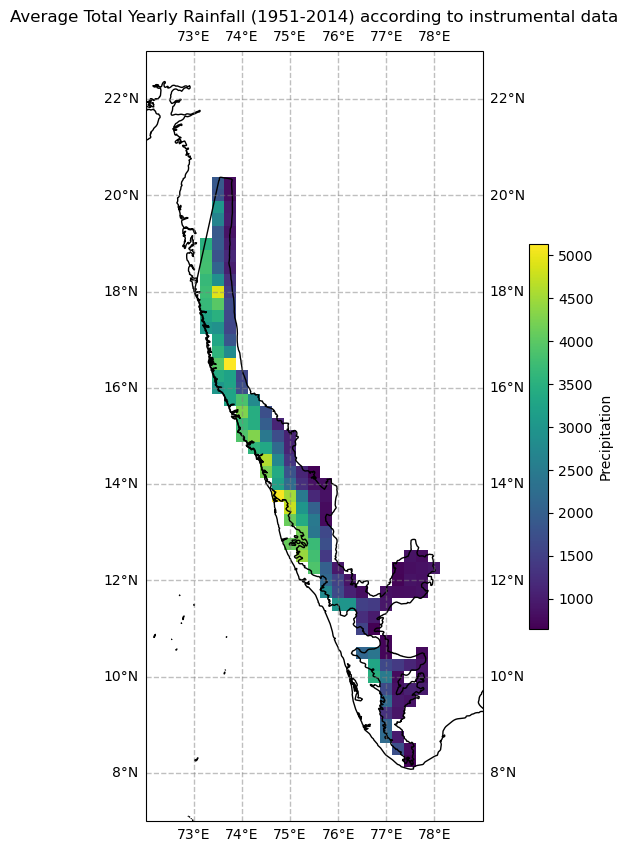

In [232]:
# Calculate the total annual rainfall for each year for each grid point
annual_rainfall = combined_ds['RAINFALL'].groupby('TIME.year').sum('TIME', skipna=True)

# Now calculate the average of the annual totals across all years for each grid point
yearly_gridded_average = annual_rainfall.mean(dim='year', skipna=True)
threshold = 0  # or another appropriate threshold value
yearly_gridded_average = yearly_gridded_average.where(yearly_gridded_average > threshold)
# Initialize the figure and axis with the cartopy projection
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(wg_feature, edgecolor='black', facecolor='none')
pcm = ax.pcolormesh(yearly_gridded_average['LONGITUDE'], yearly_gridded_average['LATITUDE'], yearly_gridded_average,
                        transform=ccrs.PlateCarree(), cmap='viridis')
# Plot custom gridlines
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add coastlines for better reference
ax.coastlines()
cbar = fig.colorbar(pcm, ax=ax, shrink=0.5)
cbar.set_label('Precipitation')

# Set the title
ax.set_title('Average Total Yearly Rainfall (1951-2014) according to instrumental data')
ax.set_extent([72, 79, 7, 23], crs=ccrs.PlateCarree())
# Display the plot
plt.show()

To similarly view maps for each of the 13 models, I am opening each model data we saved to the dictionary model_datasets earlier, calculating the average for each grid cell, and saving it to a new dictionary which we can use to plot later.

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import xarray as xr
import numpy as np
import regionmask
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

model_calc = {}
for file_name, dataset in model_datasets.items():
    # Calculate the total annual rainfall for each year for each grid point
    annual_rainfall = dataset['precipitation'].groupby('date.year').sum('date', skipna=True)

    # Now calculate the average of the annual totals across all years for each grid point
    yearly_gridded_average = annual_rainfall.mean(dim='year', skipna=True)
    # Mask out values that should be nan (e.g., values below a certain threshold or outside your region of interest)
    threshold = 0  # or another appropriate threshold value
    yearly_gridded_average = yearly_gridded_average.where(yearly_gridded_average > threshold)
    model_calc[file_name] = yearly_gridded_average



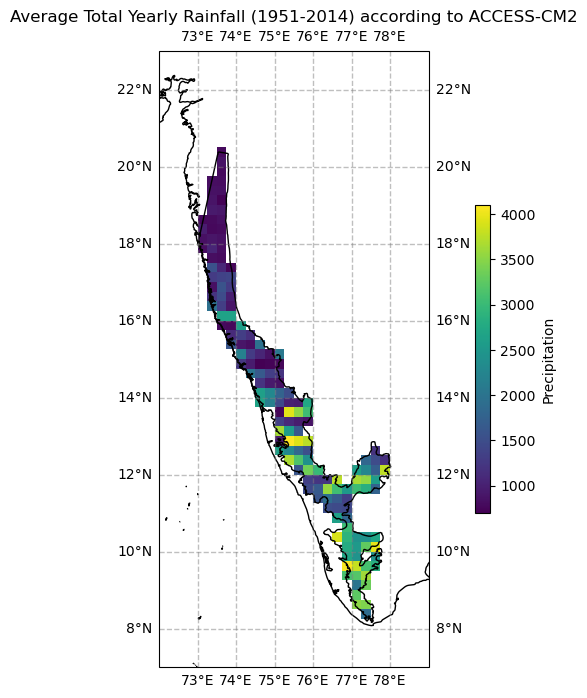

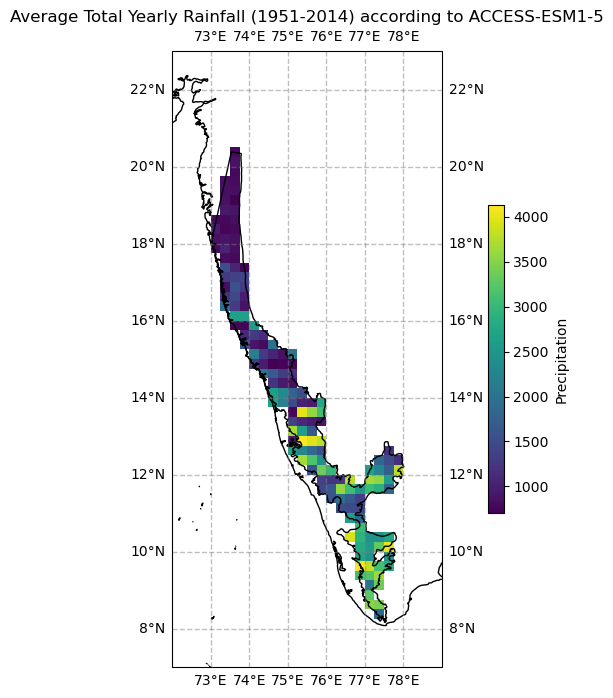

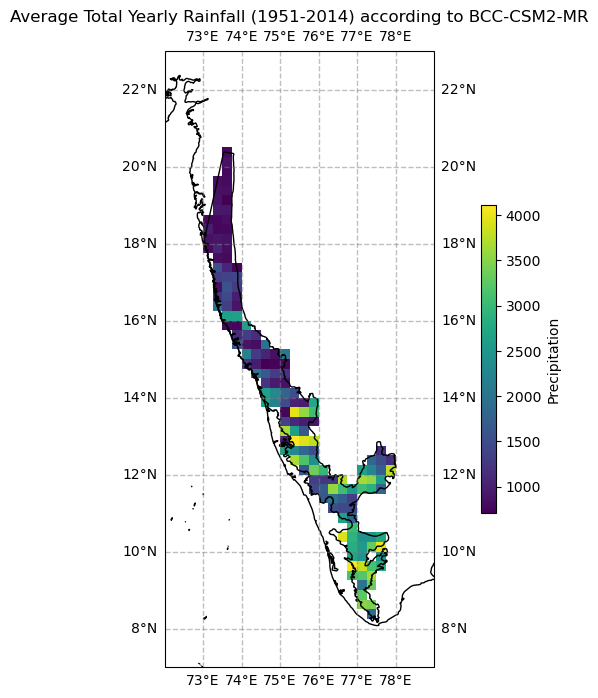

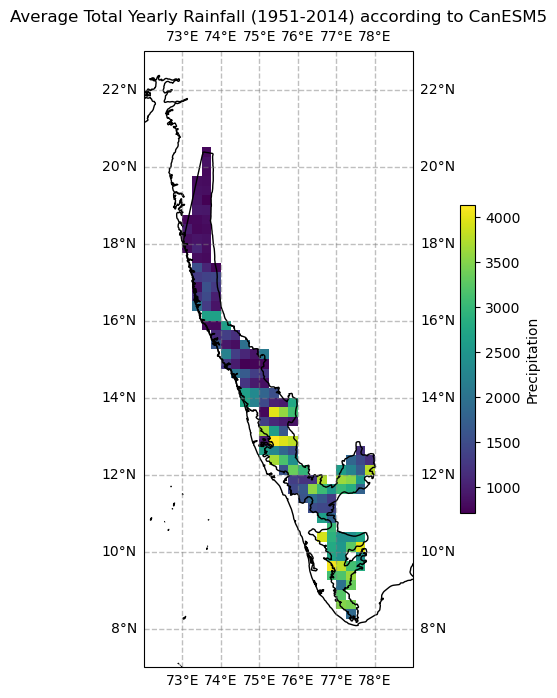

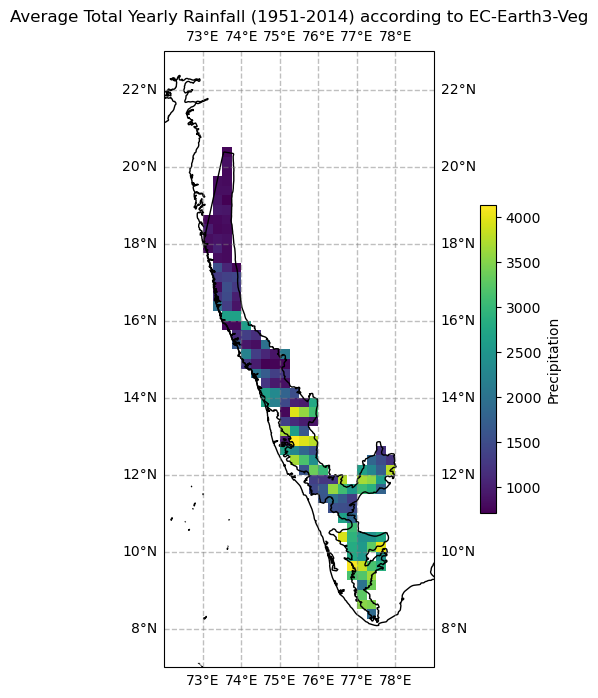

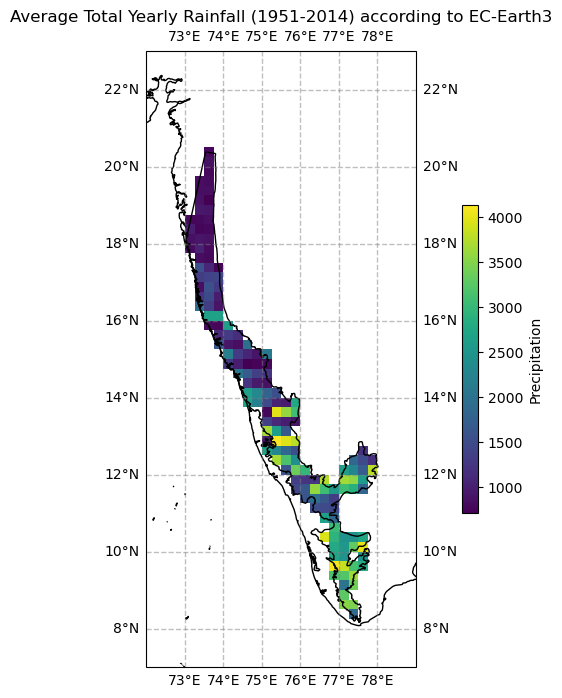

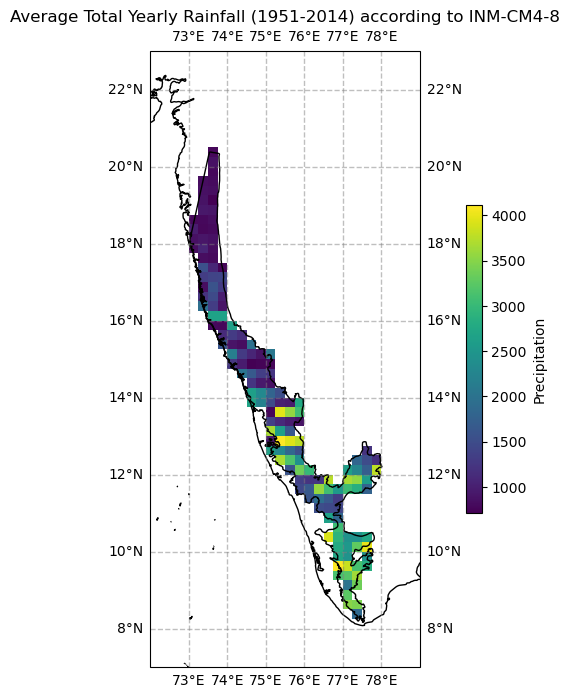

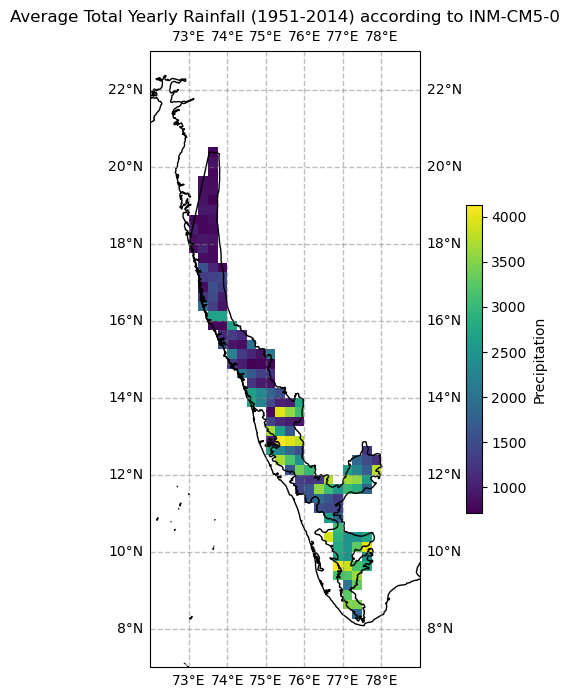

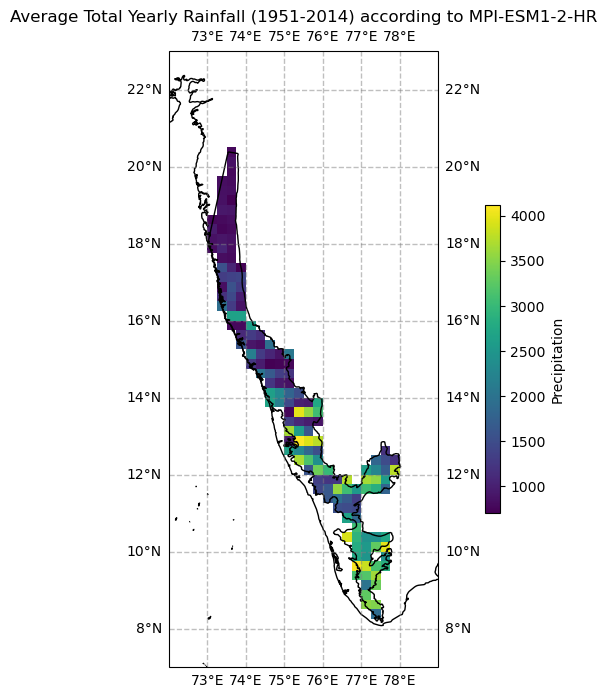

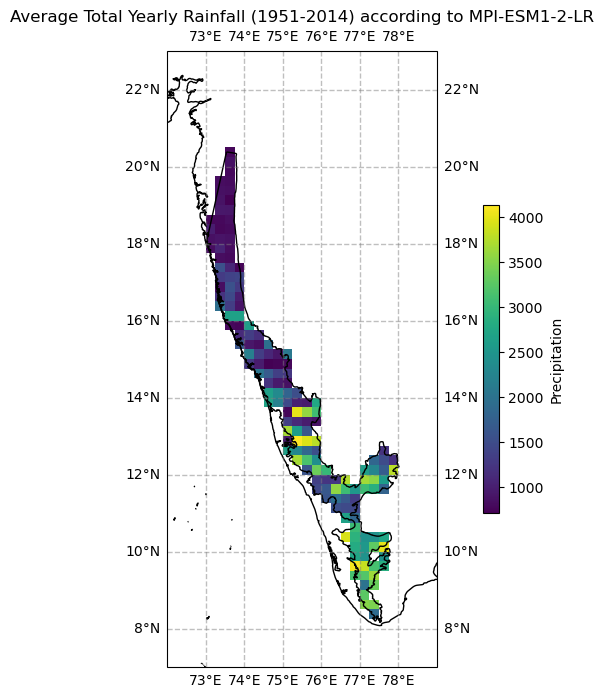

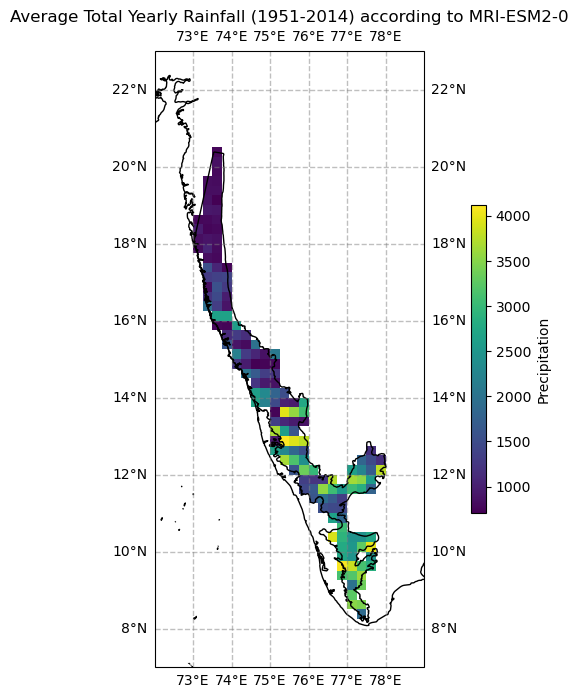

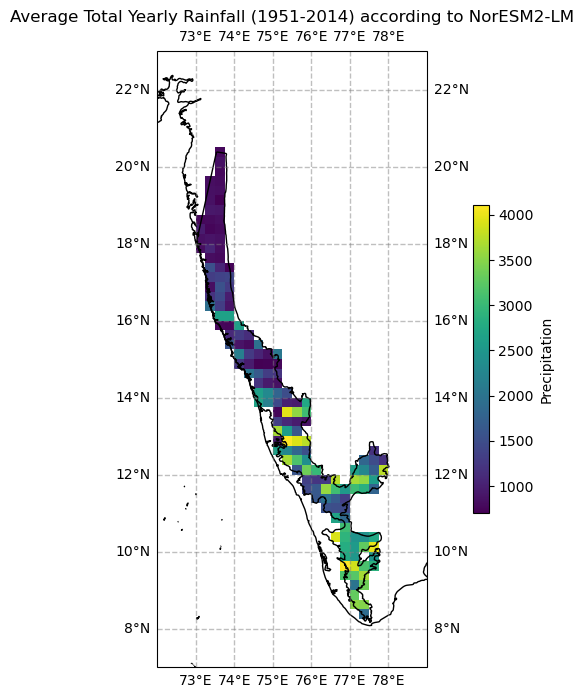

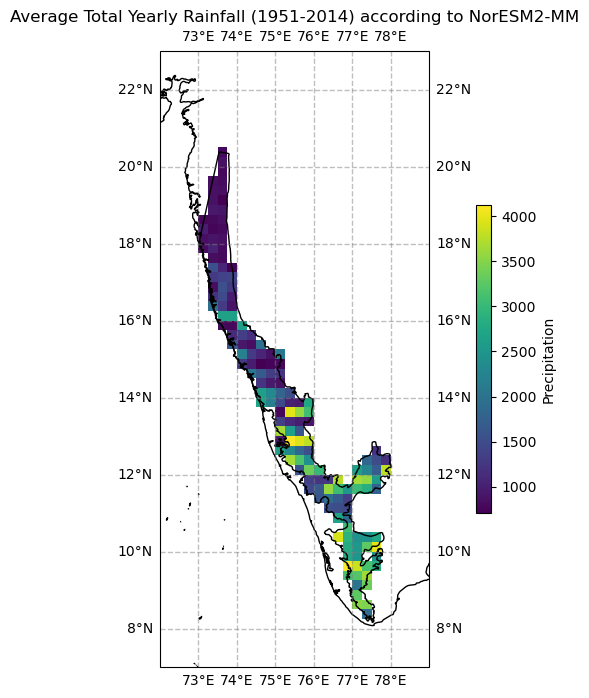

In [234]:
# Load the shapefile
shapefile_path = # path to shapefile
shapes = gpd.read_file(shapefile_path)
wg_geometry = shapes['geometry']

# Create a feature from the geometry
wg_feature = ShapelyFeature(wg_geometry, ccrs.PlateCarree())

for file_name, dataset in model_calc.items():
    # Plotting code...
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    # Add the shapefile
    ax.add_feature(wg_feature, edgecolor='black', facecolor='none')
    pcm = ax.pcolormesh(dataset['longitude'], dataset['latitude'], dataset,
                         transform=ccrs.PlateCarree(), cmap='viridis')
    # Plot custom gridlines
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

    # Add coastlines for better reference
    ax.coastlines()
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.5)
    cbar.set_label('Precipitation')
    # Split the file name and extension
    name_without_extension, _ = os.path.splitext(file_name)
    # Set the title
    ax.set_title(f'Average Total Yearly Rainfall (1951-2014) according to {name_without_extension}')
    # Focus the figure on the area of interest
    ax.set_extent([72, 79, 7, 23], crs=ccrs.PlateCarree())
    # Display the plot
    plt.show()

This is to show the degree of overlap between our two masked datasets. I have plotted the instrumental dataset and the data for one of the models, both at 50% transparency. Due to the way both datasets are structured, there is a slight discrepancy - for eg a grid cell at 8N, 77 E in the instrumental dataset will be at 8.125 N and 77.125 E in all the model datasets. However, we have ensured that there are equal number of grid cells (162 each) and that all datasets are arranged and loaded so that the corresponding values align.  

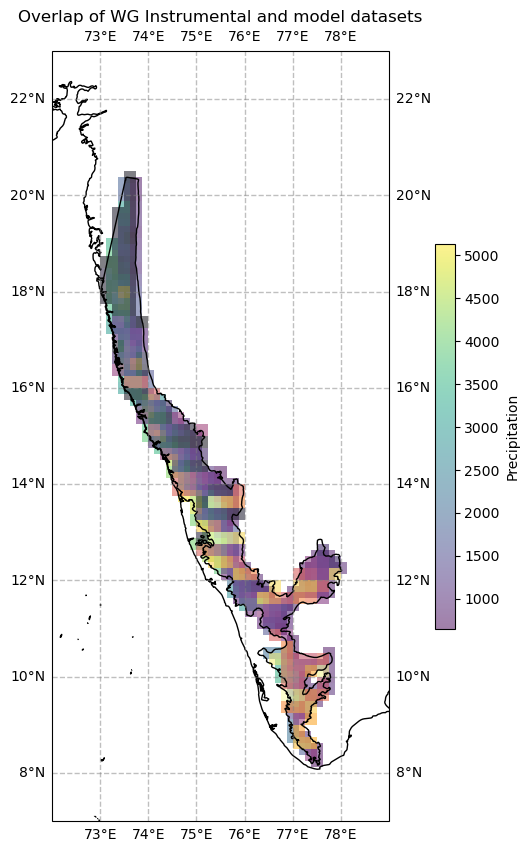

In [237]:
# Initialize the figure and axis with the cartopy projection
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(wg_feature, edgecolor='black', facecolor='none')
pcm = ax.pcolormesh(yearly_gridded_average['LONGITUDE'], yearly_gridded_average['LATITUDE'], yearly_gridded_average,
                        transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.5)
pcm1 = ax.pcolormesh(model_calc['ACCESS-CM2.nc']['longitude'], model_calc['ACCESS-CM2.nc']['latitude'], model_calc['ACCESS-CM2.nc'],
                         transform=ccrs.PlateCarree(), cmap='inferno', alpha=0.5)
# Plot custom gridlines
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add coastlines for better reference
ax.coastlines()
cbar = fig.colorbar(pcm, ax=ax, shrink=0.5)
cbar.set_label('Precipitation')

# Set the title
ax.set_title('Overlap of WG Instrumental and model datasets')
ax.set_extent([72, 79, 7, 23], crs=ccrs.PlateCarree())
# Display the plot
plt.show()

### Now that all datasets have been loaded, let's get to work! 

#### What I did was to check extreme events - in the instrumental record, for the monsoon months, check all precipitation events falling above a certain percentile - I chose 99.9. Go through the dataset and figure out for each grid cell, between 1951 and 2014, when an extremely high precipitation has occurred, and record it. Replicate the same for each of the 13 models. Then, see how many events the models managed to catch. 

First, for the instrumental record

In [143]:
# Select the monsoon months (June, July, August, September)
monsoon_ds = combined_ds.sel(TIME=combined_ds['TIME'].dt.month.isin([6, 7, 8, 9]))

# Calculate the 99.9th percentile for each grid point across all monsoon months
# Using 'load()' to load the data into memory might be necessary if you're working lazily loaded data
quantiles = monsoon_ds['RAINFALL'].load().quantile(0.999, dim='TIME')

# Identify when and where the precipitation exceeds this threshold
extreme_events = monsoon_ds['RAINFALL'].where(monsoon_ds['RAINFALL'] > quantiles)

# extreme_events now contains the precipitation values that are considered extreme
# You can convert this to a pandas DataFrame for easier handling if necessary
extreme_high_inst = extreme_events.to_dataframe().dropna(subset=['RAINFALL'])

# Now, extreme_events_df is a DataFrame with only the extreme events.
extreme_high_inst

C:\Users\hp\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


quantile    RAINFALL
TIME       LATITUDE LONGITUDE                      
1951-06-12 16.25    73.50         0.999  233.060104
           17.25    73.25         0.999  250.998795
           17.50    73.25         0.999  215.801620
1951-07-22 11.75    76.25         0.999   90.019386
1951-07-23 11.50    76.25         0.999  169.620285
...                                 ...         ...
2014-08-23 9.00     77.00         0.999  166.174789
           10.25    77.25         0.999   76.777733
2014-09-23 11.50    77.00         0.999   83.511795
           12.00    76.25         0.999   98.400002
2014-09-30 11.25    76.75         0.999   72.972664

[1295 rows x 2 columns]

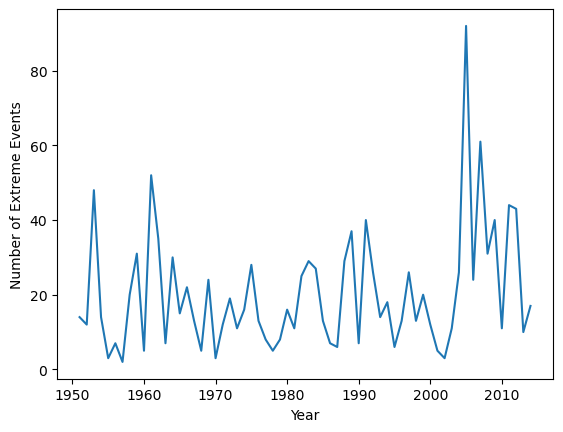

In [160]:
# Convert 'date' index level to a 'year' column
extreme_high_inst.reset_index(inplace=True)
extreme_high_inst['year'] = extreme_high_inst['TIME'].dt.year
years = np.arange(1951, 2015)
# Count of Extreme Events Per Year
events_per_year = extreme_high_inst.groupby('year').size()
events = [events_per_year.get(year, 0) for year in years]
# The events_per_year can be plotted in the same way as before
plt.plot(years, events, label='Number of Events')
plt.xlabel('Year')
plt.ylabel('Number of Extreme Events')
plt.show()


Now for the model data. As always, we deploy a for loop to go through each file from the datasets dictionary and save the data to a new dictionary.

In [ ]:
extreme_events_set = {}
for modelname, ds in model_datasets.items():
    
    # Select the monsoon months (June, July, August, September)
    monsoon_ds = ds.sel(date=ds['date'].dt.month.isin([6, 7, 8, 9]))

    # Calculate the 99.9th percentile for each grid point across all monsoon months
    # Using 'load()' to load the data into memory might be necessary if you're working lazily loaded data
    quantiles = monsoon_ds['precipitation'].load().quantile(0.999, dim='date')

    # Identify when and where the precipitation exceeds this threshold
    extreme_events = monsoon_ds['precipitation'].where(monsoon_ds['precipitation'] > quantiles)

    # extreme_events now contains the precipitation values that are considered extreme
    # You can convert this to a pandas DataFrame for easier handling if necessary
    extreme_events_df = extreme_events.to_dataframe().dropna(subset=['precipitation'])

    # Now, extreme_events_df is a DataFrame with only the extreme events.
    extreme_events_set[modelname] = extreme_events_df


Now to plot this to a graph, to see whether projected model extreme events align with the actual record. The graph is almost unreadable, but we can see there is little alignment - most models seem to vastly overstate the number of extreme events. 

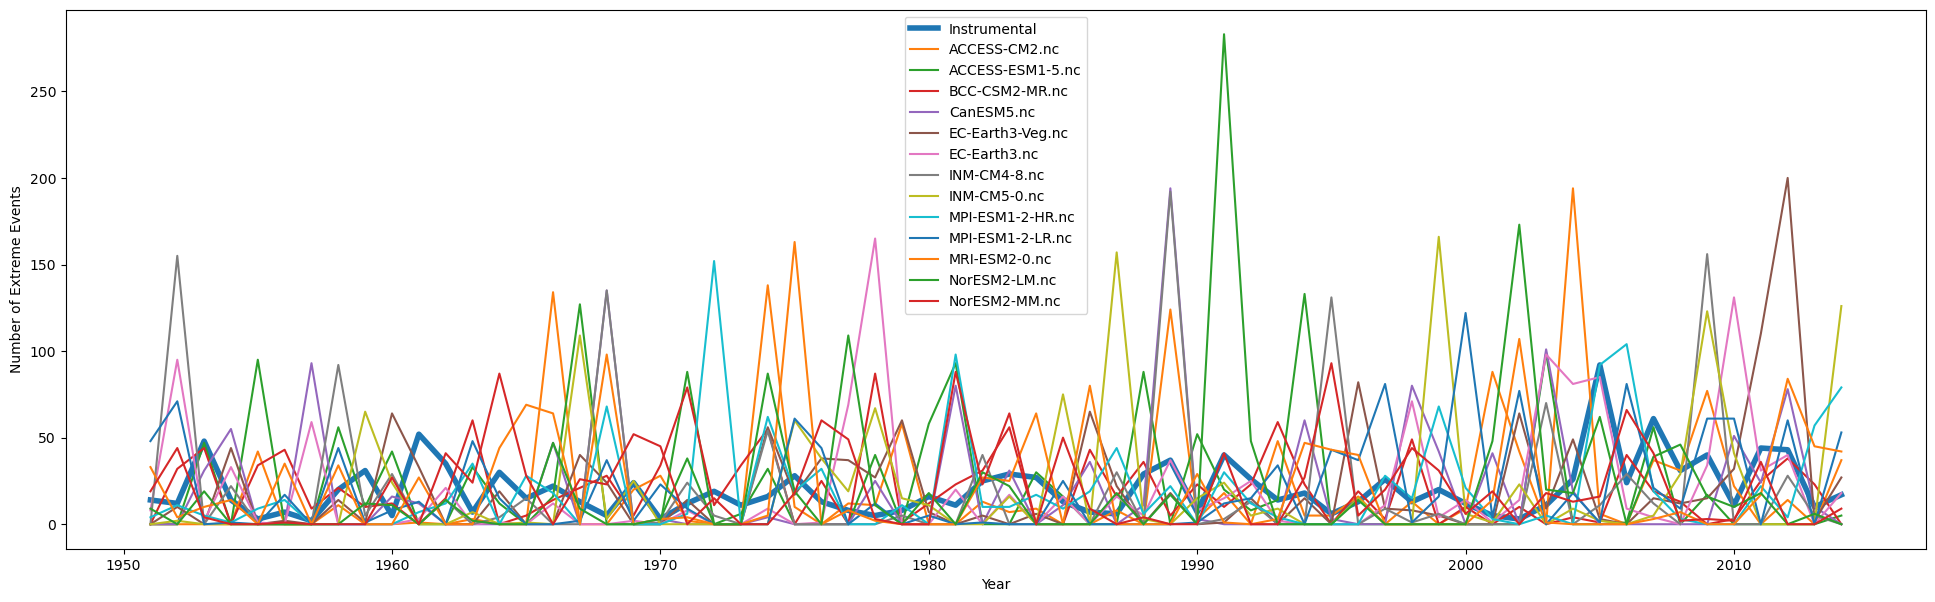

In [188]:
e_ev = {}
for modelname, ds in extreme_events_set.items():
    # Count of Extreme Events Per Year
    ds.reset_index(inplace=True)
    ds['year'] = ds['date'].dt.year
    events_per_year = ds.groupby('year').size()
    events = [events_per_year.get(year, 0) for year in years]
    e_ev[modelname] = events
    
plt.figure(figsize=(24, 7))
plt.plot(years, events, linewidth=4, label='Instrumental')
for modelname, ex in e_ev.items():
    plt.plot(years, ex, label= f'{modelname}')
    plt.xlabel('Year')
    plt.ylabel('Number of Extreme Events')
plt.legend()
plt.show()

Let us find out and quantify the alignment between the extreme events in the instrumental record and in the model records. Below, I have written a function to go through each of the 13 model outputs, and for each event recorded by the model, check to see if there is a corresponding event recorded at the same date in the same location. It corrects for the minor alignment difference between the grid cells while checking for location. If a match is found, it records the event and also records the intensity difference. At the end, we get a dataset which records the number of matches for each model. 

In [206]:
import pandas as pd

# Function to compare the intensity and timing of events between model and instrumental data
def compare_events(model_events, inst_events):
    # Align the model's dataframe index names with the instrumental's for easier comparison
    model_events.rename(columns={'date': 'TIME', 'latitude': 'LATITUDE', 'longitude': 'LONGITUDE', 'precipitation': 'RAINFALL'}, inplace=True)
    
    # Initialize a list to hold the comparison results
    comparison_results = []

    # Iterate over the model events
    for _, model_event in model_events.iterrows():
        # Find matching dates in the instrumental data within a latitude/longitude box
        match = inst_events[
            (inst_events['TIME'] == model_event['TIME']) &
            (inst_events['LATITUDE'] >= (model_event['LATITUDE'] - 0.125)) &
            (inst_events['LATITUDE'] <= (model_event['LATITUDE'] + 0.125)) &
            (inst_events['LONGITUDE'] >= (model_event['LONGITUDE'] - 0.125)) &
            (inst_events['LONGITUDE'] <= (model_event['LONGITUDE'] + 0.125))
        ]

        # If a match is found, calculate the difference in rainfall intensity
        if not match.empty:
            intensity_diff = abs(match['RAINFALL'].iloc[0] - model_event['RAINFALL'])
            comparison_results.append((model_event['TIME'], model_event['LATITUDE'], model_event['LONGITUDE'], True, intensity_diff))
        else:
            continue

    # Create a DataFrame from the results
    results_df = pd.DataFrame(comparison_results, columns=['Time', 'Latitude', 'Longitude', 'Date Match', 'Intensity Difference'])
    
    return results_df

# Dictionary to hold the comparison results for each model
comparison_results_set = {}

# Compare each model's extreme events with the instrumental data
for model_name, model_events in extreme_events_set.items():
    comparison_results_set[model_name] = compare_events(model_events, extreme_high_inst)

# Now we have a dictionary with comparison results for each model
comparison_results_set

{'ACCESS-CM2.nc':         Time  Latitude  Longitude  Date Match  Intensity Difference
 0 1974-07-25    12.625     75.125        True             77.127686,
 'ACCESS-ESM1-5.nc':         Time  Latitude  Longitude  Date Match  Intensity Difference
 0 1992-07-25    16.125     73.625        True            274.965188
 1 1992-07-25    16.125     73.875        True            274.185188,
 'BCC-CSM2-MR.nc':         Time  Latitude  Longitude  Date Match  Intensity Difference
 0 1953-07-07     8.375     77.375        True            176.225417
 1 1953-07-07     8.625     77.375        True            241.275417
 2 1959-07-01    11.125     76.625        True             98.725434
 3 1962-07-10    12.125     75.875        True             16.115414
 4 1962-07-10    12.125     76.125        True             12.805414
 5 1982-07-21     9.875     77.125        True            120.640878,
 'CanESM5.nc': Empty DataFrame
 Columns: [Time, Latitude, Longitude, Date Match, Intensity Difference]
 Index: [],

Let us combine these together, to understand the % of events captured by all models together, every year

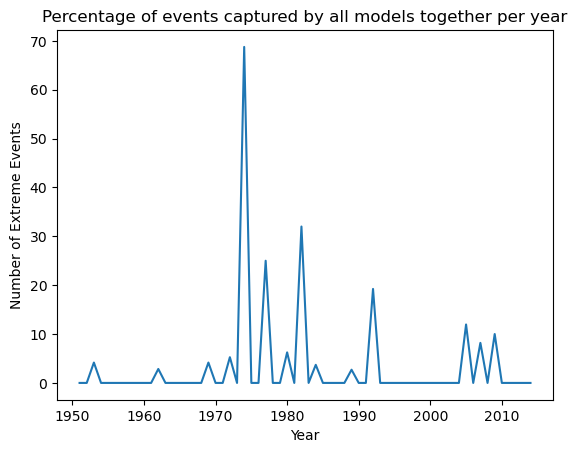

In [201]:
import pandas as pd

# Concatenate all model DataFrames into one DataFrame
all_model_events = pd.concat(comparison_results_set.values(), ignore_index=True)

# Now group by year and count the number of events for each year
events_per_year_all_models = all_model_events.groupby(all_model_events['Time'].dt.year).size()
events_per_year_inst = events_per_year
percentage_captured = (events_per_year_all_models / events_per_year_inst) * 100

# To handle any missing years in the models, you may need to reindex or fill missing values with 0
percentage_captured = percentage_captured.reindex(events_per_year_inst.index, fill_value=0)
percentage_captured = percentage_captured.fillna(0)
percentage_captured.plot(title='Percentage of events captured by all models together per year')
plt.xlabel('Year')
plt.ylabel('Number of Extreme Events')
plt.show()

In [13]:
grid_point_mapping

,latitude,longitude
grid_point,,
grid_1,23.875,68.375
grid_2,23.375,68.625
grid_3,23.625,68.625
grid_4,23.875,68.625
grid_5,23.125,68.875
...,...,...
grid_4637,28.125,96.875
grid_4638,28.375,96.875
grid_4639,27.125,97.125


### Now that we understand the poor performance of the models in capturing extreme events, let us work on quantifying it in other ways. In this section, I have transferred the yearly averages of each grid point from the instrumental dataset and each of the 13 models to a single dataframe, so that we can track the year on year correlation of each model to see if there are some improvements. Later, I implement a Random Forest ML model which highly improves this correlation, thus showing us a way to improve these model projections

In [276]:
annualavg_inst = annual_rainfall.to_dataframe().reset_index() #we had earlier calculated and stored the totals for each year for the instrumental dataset to this variable
annualavg_inst = annualavg_inst[annualavg_inst['RAINFALL'] != 0].reset_index(drop=True)

model_calc_annual = {} #to store the results fore ach individual model
for file_name, dataset in model_datasets.items():
    # Calculate the total annual rainfall for each year for each grid point
    annual_rainfall = dataset['precipitation'].groupby('date.year').sum('date', skipna=True)
    # Mask out values that should be nan (e.g., values below a certain threshold or outside your region of interest)
    threshold = 0  # or another appropriate threshold value
    annual_rainfall = annual_rainfall.where(annual_rainfall > threshold)
    dataframe = annual_rainfall.to_dataframe().dropna(subset=['precipitation'])
    dataframe.reset_index()
    name_without_extension, _ = os.path.splitext(file_name)
    model_calc_annual[name_without_extension] = dataframe

# Start with the instrumental data DataFrame and copy it to a new one we can merge everything into
inst_model_compar_yearly_df = annualavg_inst.copy()

# Rename the RAINFALL column to 'Instrumental' to avoid column name conflicts
inst_model_compar_yearly_df.rename(columns={'RAINFALL': 'Instrumental'}, inplace=True)

# Reset the index to make 'Grid point' an explicit column and start from 1
inst_model_compar_yearly_df.index += 1 # This will make the index start from 1
inst_model_compar_yearly_df.rename_axis('Grid point', axis='index', inplace=True)

#merge the instrumental dataset with the model datasets so that we get one dataframe with year, grid point, and 14 columns - instrumental and 13 models
for model_name, model_df in model_calc_annual.items():
    model_df.reset_index(inplace=True)
    model_df.index += 1  # This will make the index start from 1
    model_df.rename_axis('Grid point', axis='index', inplace=True)
    model_df.rename(columns={'precipitation': model_name}, inplace=True)
    # Assuming 'Grid point' is the index for both DataFrames and model_name is the column name in model_df
    inst_model_compar_yearly_df = inst_model_compar_yearly_df.merge(model_df[[model_name]], left_index=True, right_index=True, how='left')
    
# Replace 'LATITUDE' and 'LONGITUDE' in inst_model_compar_yearly_df with 'latitude' and 'longitude' from any of the model datasets
inst_model_compar_yearly_df['LATITUDE'] = model_calc_annual['ACCESS-CM2']['latitude'].values
inst_model_compar_yearly_df['LONGITUDE'] = model_calc_annual['ACCESS-CM2']['longitude'].values

# Set 'year' as part of a MultiIndex together with the current index
inst_model_compar_yearly_df.set_index('year', append=True, inplace=True)

# Reset the index, this will turn the MultiIndex into columns
inst_model_compar_yearly_df.reset_index(inplace=True)

# Recalculate the 'Grid point' to range from 1 to 162 for each year
inst_model_compar_yearly_df['Grid point'] = inst_model_compar_yearly_df.groupby('year').cumcount() + 1

# Set the 'year' and 'Grid point' back as a MultiIndex
inst_model_compar_yearly_df.set_index(['year', 'Grid point'], inplace=True)
inst_model_compar_yearly_df

LATITUDE  LONGITUDE  Instrumental  ACCESS-CM2  ACCESS-ESM1-5  \
year Grid point                                                                 
1951 1              8.375     77.375    751.266900      802.12        1846.88   
     2              8.625     77.125   2077.211777     1556.35        3499.50   
     3              8.625     77.375    803.975643     1516.55        3448.92   
     4              8.875     77.125   1126.560433     1369.52        3249.47   
     5              9.125     77.125   1111.930998      820.47        1777.70   
...                   ...        ...           ...         ...            ...   
2014 158           19.625     73.375   1209.466103     1403.32        1032.23   
     159           19.625     73.625   2469.243694     1387.17        1009.72   
     160           19.875     73.625    820.411164     1338.38         964.23   
     161           20.125     73.625   1669.359935     1536.92        1069.32   
     162           20.375     73.625    890.887188     1390.16         956.11   

                 BCC-CSM2-MR  CanESM5  EC-Earth3-Veg  EC-Earth3  INM-CM4-8  \
year Grid point                                                              
1951 1               1949.06  1393.45        1292.30    1817.62    1500.49   
     2               3519.61  2672.90        2487.87    3301.77    2768.44   
     3               3462.47  2721.55        2448.71    3226.47    2638.26   
     4               3303.53  2562.02        2337.80    3037.46    2396.38   
     5               2227.36  1357.83        1519.01    2069.52    1988.75   
...                      ...      ...            ...        ...        ...   
2014 158              523.24   960.08         815.79     831.73     847.63   
     159              483.77   922.50         758.99     783.31     811.52   
     160              448.43   891.65         719.43     749.30     772.81   
     161              512.34   960.67         801.74     815.56     854.06   
     162              451.15   855.70         705.76     718.62     770.40   

                 INM-CM5-0  MPI-ESM1-2-HR  MPI-ESM1-2-LR  MRI-ESM2-0  \
year Grid point                                                        
1951 1             1924.31        1844.52        1228.59     2351.42   
     2             3498.14        3563.73        2443.85     4569.63   
     3             3326.05        3570.13        2351.91     4525.29   
     4             3084.01        3500.47        2153.65     4252.41   
     5             2797.24        1951.79        1364.91     2401.35   
...                    ...            ...            ...         ...   
2014 158            969.82         523.34         937.80     1042.91   
     159            924.87         502.67         917.68     1027.90   
     160            891.85         505.91         903.91     1001.56   
     161            997.98         498.60         997.15     1124.61   
     162            872.70         454.17         901.00     1009.50   

                 NorESM2-LM  NorESM2-MM  
year Grid point                          
1951 1              1809.81     1483.02  
     2              3375.82     2824.33  
     3              3317.07     2809.79  
     4              3145.00     2672.70  
     5              1965.75     1336.08  
...                     ...         ...  
2014 158             785.25      456.68  
     159             766.56      429.83  
     160             753.39      409.20  
     161             800.45      432.85  
     162             732.73      399.66  

[10368 rows x 16 columns]

Since statistical assumptions of normal distribution cannot be met for precipitation across 162 grid points for a particular year, we are calculating the Spearman's correlation coefficient and the level of significance for each model, for each year. To put it simply, we'll be able to say - across 162 grid points for a particular year, what is the correlation of a model's projected values to the actual precipitation? Positive values indicate a positive correlation i.e model values are moving in the same direction as the instrumental dataset whereas negative values indicate the opposite. a value closer to 0 implies the model is no better than random guessing. Significance values i.e p-values indicate whether the detected correlation is statistically significant or not.

After we have all the significance values, we will be able to say whether model performances have been improving or worsening over time. 

In [278]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# code for Spearman correlation calculation
def calculate_spearman(true_vals, model_vals):
    # Calculate the Spearman correlation coefficient and return the value
    # Note: spearmanr returns a tuple with the coefficient and p-value, so index [0] is used to get the coefficient
    return spearmanr(true_vals, model_vals)

# Initialize a dictionary to store the Spearman correlation values
spearman_results = {}

# Iterate over the models
for model in inst_model_compar_yearly_df.columns[3:]:  # Assuming model data starts from the third column after Grid Point, Lat, Long
    # Extract the true and model values for each grid point
    true_vals = inst_model_compar_yearly_df.groupby('year')['Instrumental'].apply(list).to_dict()
    model_vals = inst_model_compar_yearly_df.groupby('year')[model].apply(list).to_dict()
    spearman_year = {}
    for year, true_item in true_vals.items():
        model_item = model_vals[year]
        # Compute Spearman correlation for this year
        spearman_corr, p_value = calculate_spearman(true_item, model_item)
        spearman_year[year] = {'Spearman Correlation': spearman_corr, 'p-value': p_value}
    # Store the Spearman correlation values and p-values for this model
    spearman_results[model] = spearman_year

# Convert the dictionary to a DataFrame
spearman_df_yearlyavg = pd.DataFrame(spearman_results) # Transpose for better readability
spearman_df_yearlyavg

,ACCESS-CM2,ACCESS-ESM1-5,BCC-CSM2-MR,CanESM5,EC-Earth3-Veg,EC-Earth3,INM-CM4-8,INM-CM5-0,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NorESM2-LM,NorESM2-MM
1951,"{'Spearman Correlation': -0.03447974133490272,...","{'Spearman Correlation': -0.13337030968399333,...","{'Spearman Correlation': -0.09862383055234483,...",{'Spearman Correlation': -0.009719699503641889...,"{'Spearman Correlation': -0.09249309516047313,...","{'Spearman Correlation': -0.06310959818561845,...",{'Spearman Correlation': -0.010176964298063258...,"{'Spearman Correlation': -0.11353574357041948,...","{'Spearman Correlation': 0.018516414618092975,...","{'Spearman Correlation': -0.05228201947327047,...","{'Spearman Correlation': -0.02211383353021123,...","{'Spearman Correlation': -0.09289955275551434,...",{'Spearman Correlation': -0.014693159798521227...
1952,"{'Spearman Correlation': -0.0848522568981358, ...","{'Spearman Correlation': -0.18219038304394397,...","{'Spearman Correlation': -0.23667263651259382,...","{'Spearman Correlation': 0.08782730068406248, ...","{'Spearman Correlation': -0.12103262810117969,...","{'Spearman Correlation': -0.09114670437689909,...","{'Spearman Correlation': -0.20977586968517883,...","{'Spearman Correlation': -0.22650272877000005,...","{'Spearman Correlation': -0.28629433457387576,...","{'Spearman Correlation': -0.18565656309054548,...","{'Spearman Correlation': -0.09517176361668227,...","{'Spearman Correlation': -0.258457634557928, '...","{'Spearman Correlation': -0.23445123285080602,..."
1953,"{'Spearman Correlation': -0.08656558856612204,...","{'Spearman Correlation': -0.15496054679837024,...","{'Spearman Correlation': -0.22609062593058327,...","{'Spearman Correlation': -0.22866767998803209,...","{'Spearman Correlation': 0.02234811117179749, ...",{'Spearman Correlation': -0.049538430706742256...,"{'Spearman Correlation': -0.0330063325528783, ...","{'Spearman Correlation': -0.07914209221224426,...","{'Spearman Correlation': -0.20702099042989947,...","{'Spearman Correlation': -0.15884165230657626,...","{'Spearman Correlation': -0.2383408062255755, ...","{'Spearman Correlation': -0.1754273802820082, ...","{'Spearman Correlation': -0.11578255083189731,..."
1954,"{'Spearman Correlation': -0.15991142611574727,...","{'Spearman Correlation': -0.18568478931242335,...","{'Spearman Correlation': -0.17873267086390585,...","{'Spearman Correlation': -0.2523889968541876, ...","{'Spearman Correlation': -0.18408718515413633,...","{'Spearman Correlation': -0.21803486220664134,...","{'Spearman Correlation': -0.1686587322756968, ...","{'Spearman Correlation': -0.16717403300492123,...","{'Spearman Correlation': -0.1726132259607853, ...","{'Spearman Correlation': -0.18478155021233172,...","{'Spearman Correlation': -0.15597386816378547,...","{'Spearman Correlation': -0.0779848171152519, ...","{'Spearman Correlation': -0.1339517698546773, ..."
1955,"{'Spearman Correlation': -0.1767596579546433, ...","{'Spearman Correlation': -0.18484647052265082,...","{'Spearman Correlation': -0.13223561556450328,...","{'Spearman Correlation': -0.1873388459144661, ...","{'Spearman Correlation': -0.21755219381252988,...","{'Spearman Correlation': -0.11692571281795075,...","{'Spearman Correlation': -0.290226247281462, '...","{'Spearman Correlation': -0.16669700985518535,...","{'Spearman Correlation': -0.2507490533630838, ...","{'Spearman Correlation': -0.18797675852890577,...","{'Spearman Correlation': -0.18791466084077446,...","{'Spearman Correlation': -0.07231416913998935,...","{'Spearman Correlation': -0.1420075335786192, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,"{'Spearman Correlation': -0.22259621966210388,...","{'Spearman Correlation': -0.12096206254648505,...","{'Spearman Correlation': -0.17118780175595324,...","{'Spearman Correlation': -0.04598474937231939,...","{'Spearman Correlation': -0.13552961565764982,...","{'Spearman Correlation': -0.1620989583112816, ...","{'Spearman Correlation': -0.21652475933617568,...","{'Spearman Correlation': -

We store just the statistically significant correlation values to a single dataset and fill in 'None' for the years where no statistical significance was found.

In [285]:
sig_spearman_model = {}

# Iterate over each model column in the dataframe
for model in spearman_df_yearlyavg.columns:
    significant_values = {}
    # Iterate over each year in the dataframe
    for year in spearman_df_yearlyavg.index:
        if spearman_df_yearlyavg[model][year]['p-value'] <= 0.05:
            significant_values[year] = spearman_df_yearlyavg[model][year]['Spearman Correlation']
    sig_spearman_model[model] = significant_values
sig_spearman_model

{'ACCESS-CM2': {1954: -0.15991142611574727,
  1955: -0.1767596579546433,
  1956: -0.295561003216378,
  1957: -0.1780891130050906,
  1960: -0.1698498788389426,
  1965: -0.18549285100365387,
  1970: -0.27213606167994003,
  1975: -0.2281906568382962,
  1976: -0.3112237337364038,
  1980: -0.19113809537922632,
  1982: -0.19588574589908278,
  1986: -0.15643395558039463,
  1988: -0.2884988025025368,
  1990: -0.2684497171026912,
  1991: -0.18253474295085392,
  1993: -0.31116163604827246,
  1994: -0.18315007458779128,
  1996: -0.22351921711751,
  1997: -0.21486788011194521,
  1998: -0.1574049376129931,
  2002: -0.34526737994329354,
  2003: -0.3658358278256918,
  2004: -0.37486821882660776,
  2005: -0.3187855385774831,
  2006: -0.24204973178032657,
  2007: -0.1993857974119377,
  2009: -0.16450665503746323,
  2010: -0.22259621966210388,
  2011: -0.1841803316863333,
  2012: -0.155042402841816,
  2013: -0.2923827306329307,
  2014: -0.20123743756712548},
 'ACCESS-ESM1-5': {1952: -0.18219038304394397

In [ ]:
years = np.arange(1951, 2015)
for model, year_dict in sig_spearman_model.items():
    sig_spearman_model[model] = {year: year_dict.get(year, None) for year in years}
sig_spearman_model

#### We will now plot the trends for each of the 13 models. As we can see, all models show negative correlations and flat or worsening performances over time - not good.

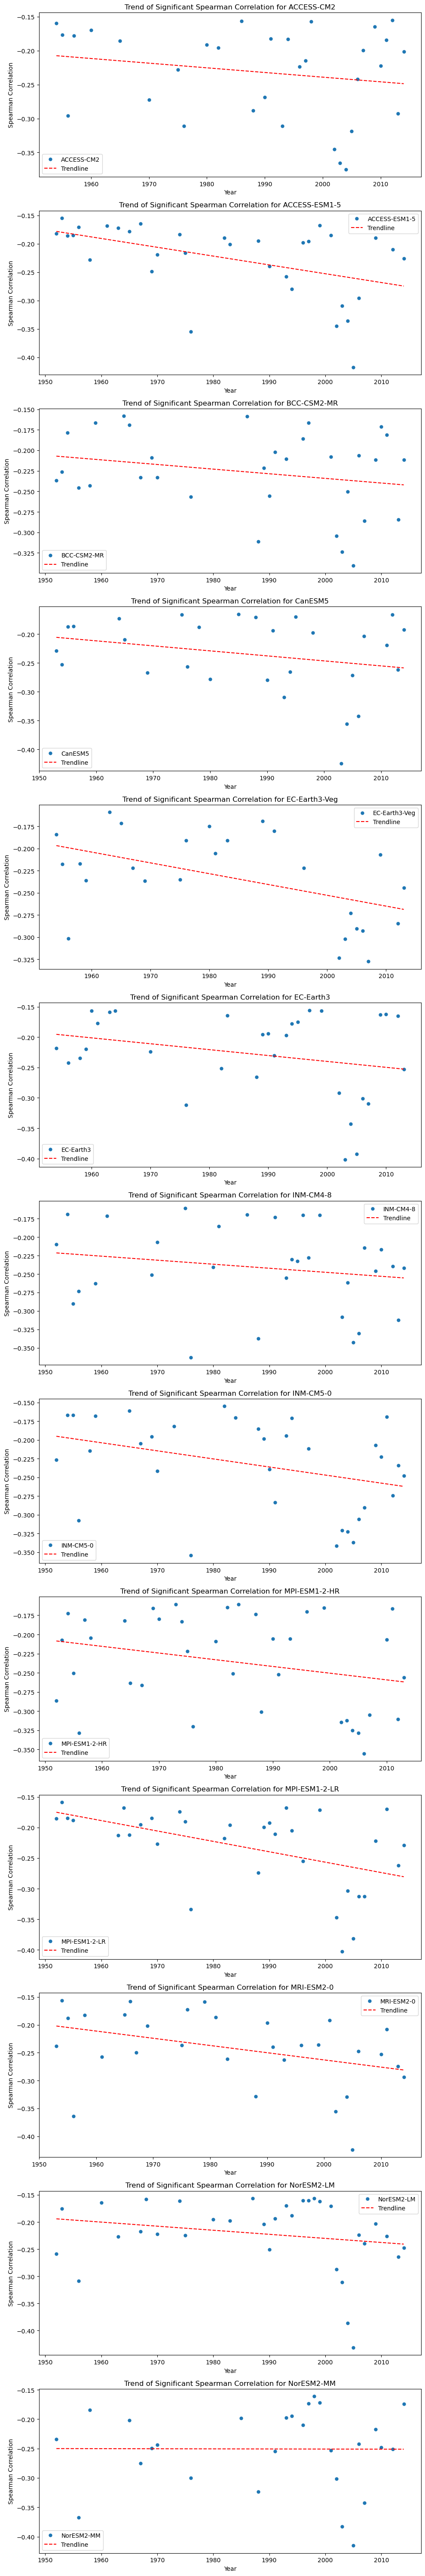

In [289]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure for plotting
fig, axes = plt.subplots(nrows=13, ncols=1, figsize=(10, 60))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the array to easily iterate over it

# Iterate over each model and its dictionary of years and Spearman correlation values
for idx, (model, yearly_data) in enumerate(sig_spearman_model.items()):
    # Prepare the data for plotting and trend line
    x_values = [year for year, value in yearly_data.items() if value is not None]
    y_values = [value for year, value in yearly_data.items() if value is not None]

    # Only plot and fit a trend line if there are enough data points
    if y_values:
        axes[idx].plot(x_values, y_values, label=model, marker='o', linestyle='', markersize=5)
        
        # Fit a linear trend line to the significant values
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        
        # Plot the trend line
        axes[idx].plot(x_values, p(x_values), "r--", label='Trendline')

    # Set the title and labels for each subplot
    axes[idx].set_title(f'Trend of Significant Spearman Correlation for {model}')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Spearman Correlation')
    axes[idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [291]:
inst_model_compar_yearly_df['Model Average'] = inst_model_compar_yearly_df.iloc[:, 3:].mean(axis=1)
inst_model_compar_yearly_df

LATITUDE  LONGITUDE  Instrumental  ACCESS-CM2  ACCESS-ESM1-5  \
year Grid point                                                                 
1951 1              8.375     77.375    751.266900      802.12        1846.88   
     2              8.625     77.125   2077.211777     1556.35        3499.50   
     3              8.625     77.375    803.975643     1516.55        3448.92   
     4              8.875     77.125   1126.560433     1369.52        3249.47   
     5              9.125     77.125   1111.930998      820.47        1777.70   
...                   ...        ...           ...         ...            ...   
2014 158           19.625     73.375   1209.466103     1403.32        1032.23   
     159           19.625     73.625   2469.243694     1387.17        1009.72   
     160           19.875     73.625    820.411164     1338.38         964.23   
     161           20.125     73.625   1669.359935     1536.92        1069.32   
     162           20.375     73.625    890.887188     1390.16         956.11   

                 BCC-CSM2-MR  CanESM5  EC-Earth3-Veg  EC-Earth3  INM-CM4-8  \
year Grid point                                                              
1951 1               1949.06  1393.45        1292.30    1817.62    1500.49   
     2               3519.61  2672.90        2487.87    3301.77    2768.44   
     3               3462.47  2721.55        2448.71    3226.47    2638.26   
     4               3303.53  2562.02        2337.80    3037.46    2396.38   
     5               2227.36  1357.83        1519.01    2069.52    1988.75   
...                      ...      ...            ...        ...        ...   
2014 158              523.24   960.08         815.79     831.73     847.63   
     159              483.77   922.50         758.99     783.31     811.52   
     160              448.43   891.65         719.43     749.30     772.81   
     161              512.34   960.67         801.74     815.56     854.06   
     162              451.15   855.70         705.76     718.62     770.40   

                 INM-CM5-0  MPI-ESM1-2-HR  MPI-ESM1-2-LR  MRI-ESM2-0  \
year Grid point                                                        
1951 1             1924.31        1844.52        1228.59     2351.42   
     2             3498.14        3563.73        2443.85     4569.63   
     3             3326.05        3570.13        2351.91     4525.29   
     4             3084.01        3500.47        2153.65     4252.41   
     5             2797.24        1951.79        1364.91     2401.35   
...                    ...            ...            ...         ...   
2014 158            969.82         523.34         937.80     1042.91   
     159            924.87         502.67         917.68     1027.90   
     160            891.85         505.91         903.91     1001.56   
     161            997.98         498.60         997.15     1124.61   
     162            872.70         454.17         901.00     1009.50   

                 NorESM2-LM  NorESM2-MM  Model Average  
year Grid point                                         
1951 1              1809.81     1483.02    1634.122308  
     2              3375.82     2824.33    3083.226154  
     3              3317.07     2809.79    3027.936154  
     4              3145.00     2672.70    2851.109231  
     5              1965.75     1336.08    1813.673846  
...                     ...         ...            ...  
2014 158             785.25      456.68     856.140000  
     159             766.56      429.83     825.114615  
     160             753.39      409.20     796.157692  
     161             800.45      432.85     877.096154  
     162             732.73      399.66     785.973846  

[10368 rows x 17 columns]

In [302]:

true_vals = inst_model_compar_yearly_df.groupby('year')['Instrumental'].apply(list).to_dict()
model_vals = inst_model_compar_yearly_df.groupby('year')['Model Average'].apply(list).to_dict()
spearman_year = {}
for year, true_item in true_vals.items():
    model_item = model_vals[year]
    # Compute Spearman correlation for this year
    spearman_corr, p_value = calculate_spearman(true_item, model_item)
    spearman_year[year] = {'Spearman Correlation': spearman_corr, 'p-value': p_value}
    # Store the Spearman correlation values and p-values for this model
spearman_results['Model Average'] = spearman_year

# Convert the dictionary to a DataFrame
spearman_df_yearlyavg = pd.DataFrame(spearman_results)
spearman_df_yearlyavg

,ACCESS-CM2,ACCESS-ESM1-5,BCC-CSM2-MR,CanESM5,EC-Earth3-Veg,EC-Earth3,INM-CM4-8,INM-CM5-0,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NorESM2-LM,NorESM2-MM,Model Average
1951,"{'Spearman Correlation': -0.03447974133490272,...","{'Spearman Correlation': -0.13337030968399333,...","{'Spearman Correlation': -0.09862383055234483,...",{'Spearman Correlation': -0.009719699503641889...,"{'Spearman Correlation': -0.09249309516047313,...","{'Spearman Correlation': -0.06310959818561845,...",{'Spearman Correlation': -0.010176964298063258...,"{'Spearman Correlation': -0.11353574357041948,...","{'Spearman Correlation': 0.018516414618092975,...","{'Spearman Correlation': -0.05228201947327047,...","{'Spearman Correlation': -0.02211383353021123,...","{'Spearman Correlation': -0.09289955275551434,...","{'Spearman Correlation': -0.05433406580379106,...","{'Spearman Correlation': -0.05433406580379106,..."
1952,"{'Spearman Correlation': -0.0848522568981358, ...","{'Spearman Correlation': -0.18219038304394397,...","{'Spearman Correlation': -0.23667263651259382,...","{'Spearman Correlation': 0.08782730068406248, ...","{'Spearman Correlation': -0.12103262810117969,...","{'Spearman Correlation': -0.09114670437689909,...","{'Spearman Correlation': -0.20977586968517883,...","{'Spearman Correlation': -0.22650272877000005,...","{'Spearman Correlation': -0.28629433457387576,...","{'Spearman Correlation': -0.18565656309054548,...","{'Spearman Correlation': -0.09517176361668227,...","{'Spearman Correlation': -0.258457634557928, '...","{'Spearman Correlation': -0.1910872881798462, ...","{'Spearman Correlation': -0.1910872881798462, ..."
1953,"{'Spearman Correlation': -0.08656558856612204,...","{'Spearman Correlation': -0.15496054679837024,...","{'Spearman Correlation': -0.22609062593058327,...","{'Spearman Correlation': -0.22866767998803209,...","{'Spearman Correlation': 0.02234811117179749, ...",{'Spearman Correlation': -0.049538430706742256...,"{'Spearman Correlation': -0.0330063325528783, ...","{'Spearman Correlation': -0.07914209221224426,...","{'Spearman Correlation': -0.20702099042989947,...","{'Spearman Correlation': -0.15884165230657626,...","{'Spearman Correlation': -0.2383408062255755, ...","{'Spearman Correlation': -0.1754273802820082, ...","{'Spearman Correlation': -0.15255567269437637,...","{'Spearman Correlation': -0.15255567269437637,..."
1954,"{'Spearman Correlation': -0.15991142611574727,...","{'Spearman Correlation': -0.18568478931242335,...","{'Spearman Correlation': -0.17873267086390585,...","{'Spearman Correlation': -0.2523889968541876, ...","{'Spearman Correlation': -0.18408718515413633,...","{'Spearman Correlation': -0.21803486220664134,...","{'Spearman Correlation': -0.1686587322756968, ...","{'Spearman Correlation': -0.16717403300492123,...","{'Spearman Correlation': -0.1726132259607853, ...","{'Spearman Correlation': -0.18478155021233172,...","{'Spearman Correlation': -0.15597386816378547,...","{'Spearman Correlation': -0.0779848171152519, ...","{'Spearman Correlation': -0.1828057146808814, ...","{'Spearman Correlation': -0.1828057146808814, ..."
1955,"{'Spearman Correlation': -0.1767596579546433, ...","{'Spearman Correlation': -0.18484647052265082,...","{'Spearman Correlation': -0.13223561556450328,...","{'Spearman Correlation': -0.1873388459144661, ...","{'Spearman Correlation': -0.21755219381252988,...","{'Spearman Correlation': -0.11692571281795075,...","{'Spearman Correlation': -0.290226247281462, '...","{'Spearman Correlation': -0.16669700985518535,...","{'Spearman Correlation': -0.2507490533630838, ...","{'Spearman Correlation': -0.18797675852890577,...","{'Spearman Correlation': -0.18791466084077446,...","{'Spearman Correlation': -0.07231416913998935,...","{'Spearman Correlation': -0.18548438313709054,...","{'Spearman Correlation': -0.18548438313709054,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,"{'Spearman Correlation': -0.22259621966210388,...","{'Spearman Correlation': -0.12096206254648505,...","{'Spea

In [303]:
# Iterate over each year in the dataframe
for year in spearman_df_yearlyavg.index:
    if spearman_df_yearlyavg['Model Average'][year]['p-value'] <= 0.05:
        significant_values[year] = spearman_df_yearlyavg['Model Average'][year]['Spearman Correlation']
sig_spearman_model['Model Average'] = significant_values
sig_spearman_model['Model Average']

{1952: -0.1910872881798462,
 1956: -0.288416946459091,
 1958: -0.18297789463433636,
 1965: -0.18230046530926766,
 1967: -0.209614980220475,
 1969: -0.21073273860683836,
 1970: -0.218144944471965,
 1976: -0.29724610866248635,
 1985: -0.19838941177964917,
 1988: -0.26419602546569737,
 1991: -0.21451505233847193,
 1993: -0.23254878549623814,
 1994: -0.20673308296674528,
 1996: -0.1863142340602997,
 1997: -0.1655257384514508,
 1998: -0.16117878347806328,
 1999: -0.17168740588319142,
 2001: -0.1551694208402664,
 2002: -0.310535013922584,
 2003: -0.353856619260727,
 2005: -0.3732254527133161,
 2006: -0.2951065610441444,
 2007: -0.2697650590421996,
 2009: -0.1891340336258981,
 2010: -0.1819194113139165,
 2012: -0.19595913407596524,
 2014: -0.21329567955334824,
 1954: -0.1828057146808814,
 1955: -0.18548438313709054,
 1959: -0.15873439266344042,
 1975: -0.1809794781253837,
 1980: -0.1590025417712801,
 1982: -0.16915833640293496,
 1983: -0.16376430540207548,
 1989: -0.16472681956811056,
 1990: 

In [304]:
sig_spearman_model['Model Average'] = {year: year_dict.get(year, None) for year in years}
sig_spearman_model['Model Average']

{1951: None,
 1952: -0.23445123285080602,
 1953: None,
 1954: None,
 1955: None,
 1956: -0.3674249641174155,
 1957: None,
 1958: -0.1840363779547562,
 1959: None,
 1960: None,
 1961: None,
 1962: None,
 1963: None,
 1964: None,
 1965: -0.20199672293564,
 1966: None,
 1967: -0.27550062732778124,
 1968: None,
 1969: -0.24941959831263644,
 1970: -0.24363886807205024,
 1971: None,
 1972: None,
 1973: None,
 1974: None,
 1975: None,
 1976: -0.3001759904934085,
 1977: None,
 1978: None,
 1979: None,
 1980: None,
 1981: None,
 1982: None,
 1983: None,
 1984: None,
 1985: -0.19838941177964917,
 1986: None,
 1987: None,
 1988: -0.32366302971797767,
 1989: None,
 1990: None,
 1991: -0.2544099943406425,
 1992: None,
 1993: -0.1976019001892568,
 1994: -0.19495428057711334,
 1995: None,
 1996: -0.20991700079456813,
 1997: -0.17316081466521582,
 1998: -0.16117878347806328,
 1999: -0.17168740588319142,
 2000: None,
 2001: -0.25300150586893716,
 2002: -0.3018300470954512,
 2003: -0.38247518562269156,


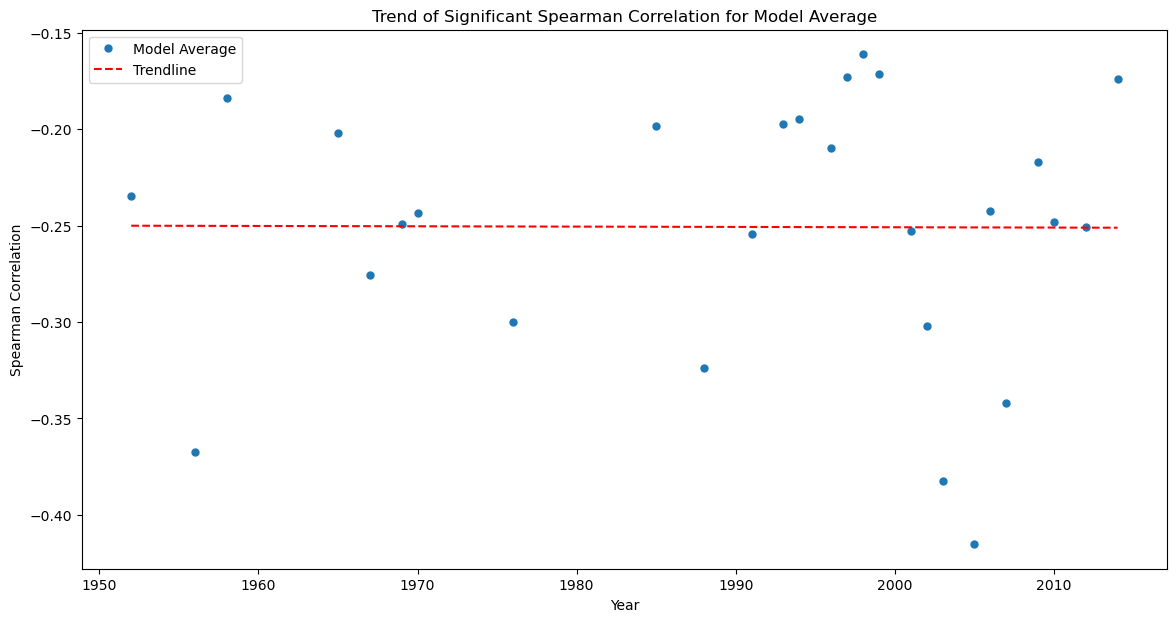

In [306]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming sig_spearman_model['Model Average'] is a dictionary with years as keys and Spearman correlation values or None
yearly_data = sig_spearman_model['Model Average']

# Prepare the data for plotting and trend line
x_values = [year for year, value in yearly_data.items() if value is not None]
y_values = [value for year, value in yearly_data.items() if value is not None]

# Create a figure and axis
plt.figure(figsize=(14, 7))

# Only plot and fit a trend line if there are enough data points
if y_values:
    plt.plot(x_values, y_values, label='Model Average', marker='o', linestyle='', markersize=5)
    
    # Fit a linear trend line to the significant values
    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)
    
    # Plot the trend line
    plt.plot(x_values, p(x_values), "r--", label='Trendline')

# Set the title and labels
plt.title('Trend of Significant Spearman Correlation for Model Average')
plt.xlabel('Year')
plt.ylabel('Spearman Correlation')
plt.legend()

# Show the plot
plt.show()


## To try and improve the poor performance of these models, I attempted a random forest model to predict the Instrumental precipitation values, giving the 13 model outputs as features to train on. 

In [309]:
#ATTEMPTING AI MODELS

features = inst_model_compar_yearly_df.columns[3:16]  # This excludes 'year', 'LATITUDE', 'LONGITUDE', and 'Instrumental'
target = 'Instrumental'

from sklearn.model_selection import train_test_split

# Use 80% of the data for training and 20% for testing
train_df, test_df = train_test_split(inst_model_compar_yearly_df, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Fit the model
rf_model.fit(train_df[features], train_df[target])

RandomForestRegressor(random_state=42)

In [311]:
# Predictions for the training set
train_df['RF_Calibrated'] = rf_model.predict(train_df[features])

# Predictions for the test set
test_df['RF_Calibrated'] = rf_model.predict(test_df[features])

from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE for the test set
rmse_test = mean_squared_error(test_df[target], test_df['RF_Calibrated'], squared=False)

# Calculate R-squared for the test set
r2_test = r2_score(test_df[target], test_df['RF_Calibrated'])

print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

#Adding predictions back into the dataframe
inst_model_compar_yearly_df['RF_Calibrated'] = rf_model.predict(inst_model_compar_yearly_df[features])

Test RMSE: 1398.1806954994875
Test R²: 0.07729178055901753


##### Plotting the RF Calibrated values against the Instrumental data and the Average (mean of 13) model outputs, we can see a significant improvement - the RF output closely aligns with the year on year variability of the instrumental data.

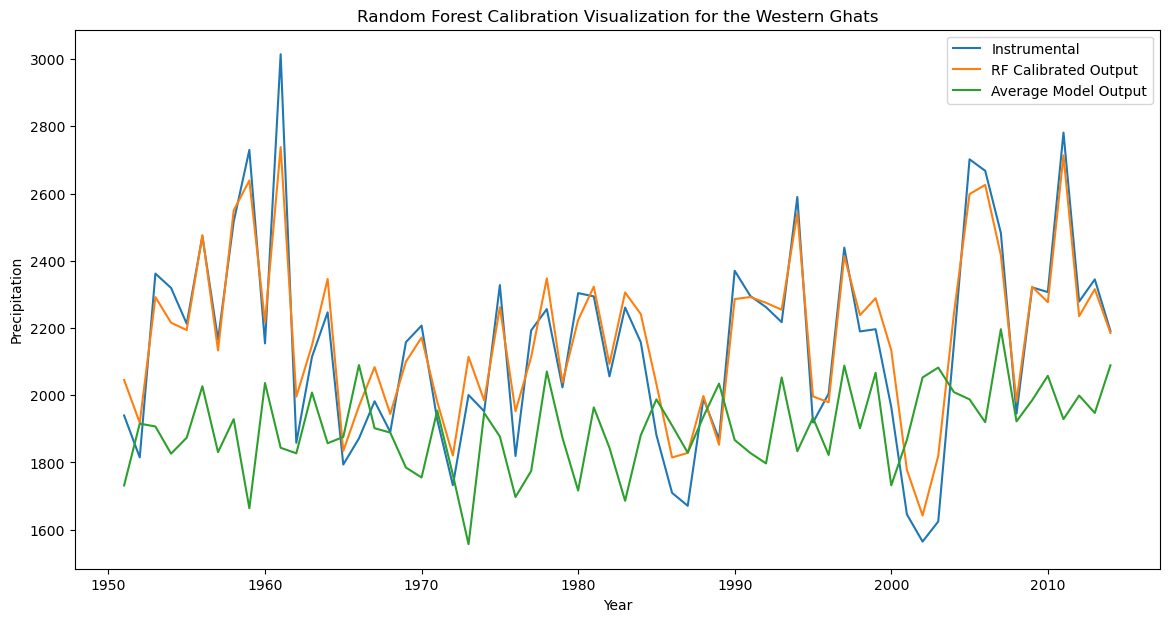

In [319]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(years, inst_model_compar_yearly_df['Instrumental'].groupby('year').mean(), label='Instrumental')
plt.plot(years, inst_model_compar_yearly_df['RF_Calibrated'].groupby('year').mean(), label='RF Calibrated Output')
plt.plot(years, inst_model_compar_yearly_df['Model Average'].groupby('year').mean(), label='Average Model Output')

plt.legend()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.title(f'Random Forest Calibration Visualization for the Western Ghats')
plt.show()

Now I will calculate the spearman's correlation for the RF output, and plot that. 

In [ ]:
true_vals = inst_model_compar_yearly_df.groupby('year')['Instrumental'].apply(list).to_dict()
model_vals = inst_model_compar_yearly_df.groupby('year')['RF_Calibrated'].apply(list).to_dict()
spearman_year = {}
for year, true_item in true_vals.items():
    model_item = model_vals[year]
    # Compute Spearman correlation for this year
    spearman_corr, p_value = calculate_spearman(true_item, model_item)
    spearman_year[year] = {'Spearman Correlation': spearman_corr, 'p-value': p_value}
    # Store the Spearman correlation values and p-values for this model
spearman_results['RF_Calibrated'] = spearman_year

# Convert the dictionary to a DataFrame
spearman_df_yearlyavg = pd.DataFrame(spearman_results)


In [ ]:
# Iterate over each year in the dataframe
for year in spearman_df_yearlyavg.index:
    if spearman_df_yearlyavg['RF_Calibrated'][year]['p-value'] <= 0.05:
        significant_values[year] = spearman_df_yearlyavg['RF_Calibrated'][year]['Spearman Correlation']
sig_spearman_model['RF_Calibrated'] = significant_values
sig_spearman_model['RF_Calibrated'] = {year: year_dict.get(year, None) for year in years}

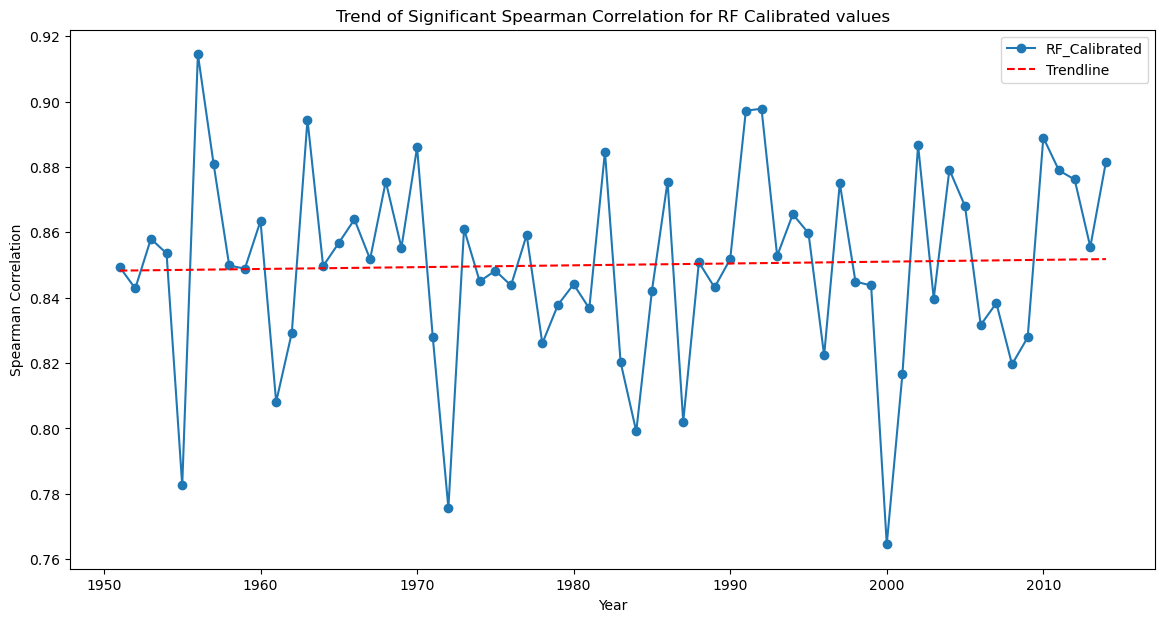

In [345]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the dictionary by year just to be safe
sorted_data = dict(sorted(sig_spearman_model['RF_Calibrated'].items()))

# Extract years and corresponding Spearman correlation values
years = list(sorted_data.keys())
spearman_values = list(sorted_data.values())

# Create a figure and axis
plt.figure(figsize=(14, 7))

# Plot the significant values
plt.plot(years, spearman_values, marker='o', linestyle='-', label='RF_Calibrated')

# Fit a linear trend line to the significant values
z = np.polyfit(years, spearman_values, 1)
p = np.poly1d(z)

# Create values for the trend line based on the years and polynomial
trendline_values = p(years)

# Plot the trend line
plt.plot(years, trendline_values, "r--", label='Trendline')

# Set the title and labels
plt.title('Trend of Significant Spearman Correlation for RF Calibrated values')
plt.xlabel('Year')
plt.ylabel('Spearman Correlation')
plt.legend()

# Show the plot
plt.show()


#### This is just a beginning - an RF model trained on model outputs has been able to significantly outperform any individual model, and the average of the models, for predicting yearly variability. Caution must be taken on whether this is an overfitted model. Also, the model could be significantly improved with more feature sets - for eg, air temperature, sea surface temperature, El Nino Southern Oscillation Index, etc. These correlations stand for the area of Western Ghats as a whole - however I have not tested for the performance in individual grid points, or temporal resolutions less than the year - month and day. It remains to be seen whether a much improved model can better predict the extreme events as well.

#### With an improved Random Forest (or other suitable algorithms) the reliability of future climate change projections can also be improved. 

### References

1. Li, Gen, Shang-Ping Xie, and Yan Du. "Monsoon-induced biases of climate models over the tropical Indian Ocean." Journal of Climate 28.8 (2015): 3058-3072.
2. Wang, Ziqian, Gen Li, and Song Yang. "Origin of Indian summer monsoon rainfall biases in CMIP5 multimodel ensemble." Climate dynamics 51 (2018): 755-768.
3. Mishra, V., Bhatia, U. & Tiwari, A.D. Bias-corrected climate projections for South Asia from Coupled Model Intercomparison Project-6. Sci Data 7, 338 (2020). https://doi.org/10.1038/s41597-020-00681-1
4. Pai D.S., Latha Sridhar, Rajeevan M., Sreejith O.P., Satbhai N.S. and Mukhopadhyay B., 2014: Development of a new high spatial resolution (0.25° X 0.25°)Long period (1901-2010) daily gridded rainfall data set over India and its comparison with existing data sets over the region; MAUSAM, 65, 1(January 2014), pp1-18.

